## Interpreting Housing rent in Dallas using open textual data 
* [Dashboard](https://app.powerbi.com/view?r=eyJrIjoiYzAyNTUyMWQtMjdlYS00NjIwLThjMDYtMDhkOWVmNjBjY2Q3IiwidCI6IjhkMjgxZDFkLTljNGQtNGJmNy1iMTZlLTAzMmQxNWRlOWY2YyIsImMiOjN9)

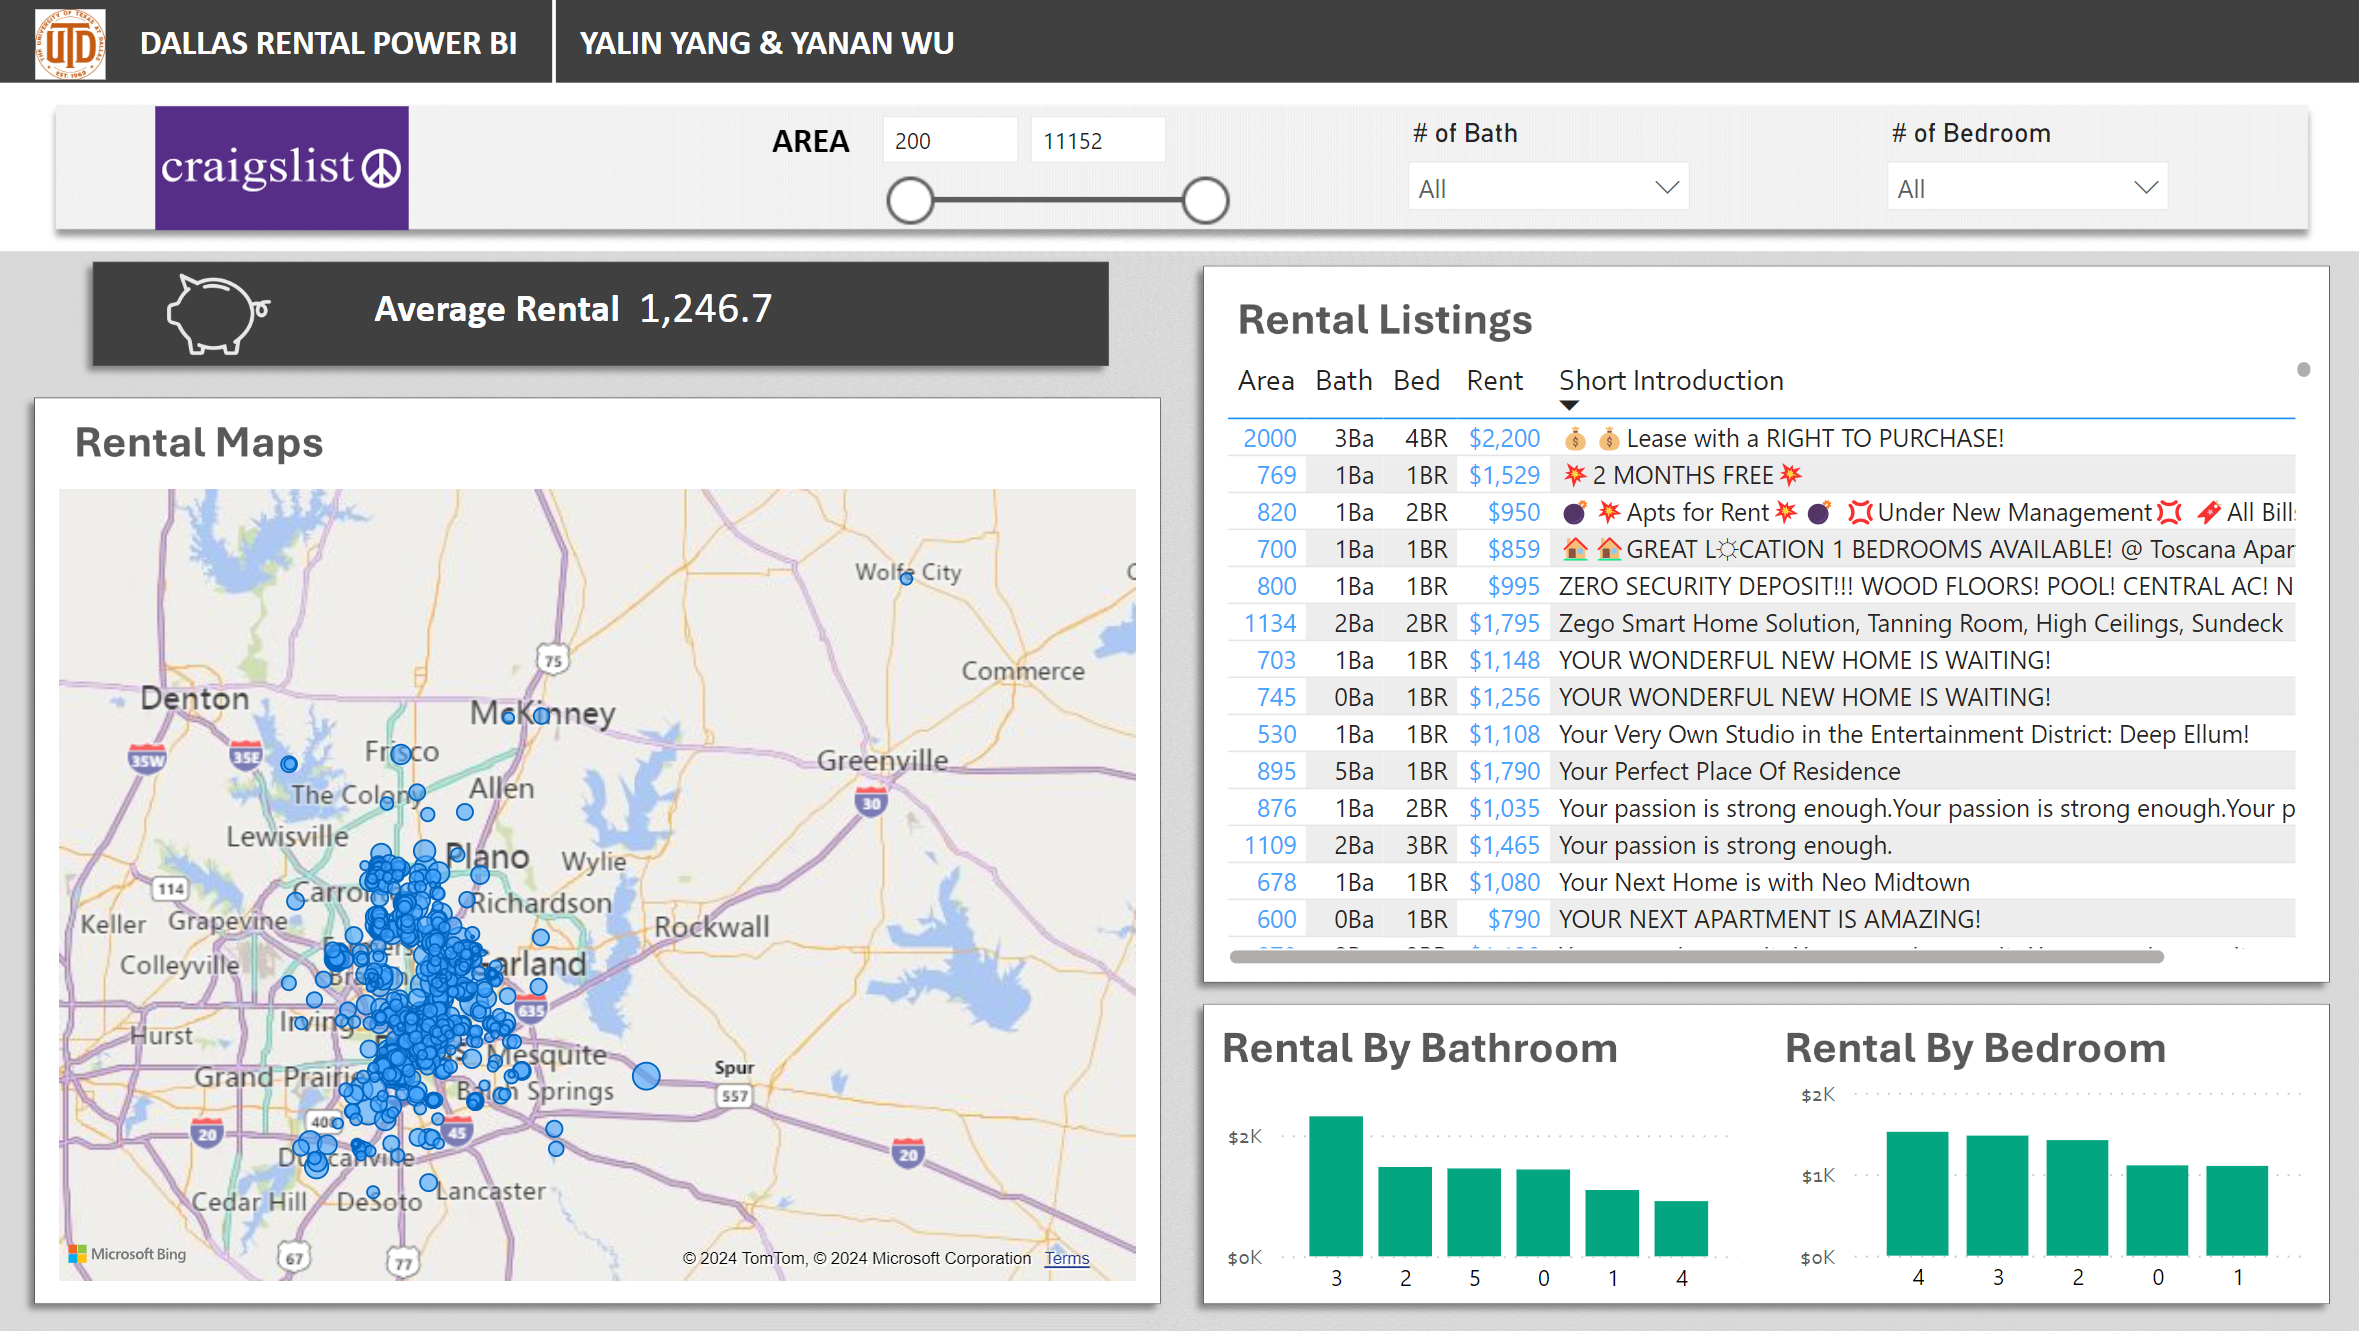

## Load Libraries

In [9]:
import pandas as pd
import numpy as np
import re, string
from tensorflow.keras.layers import  Dropout, Dense
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

## Preparing Text Data
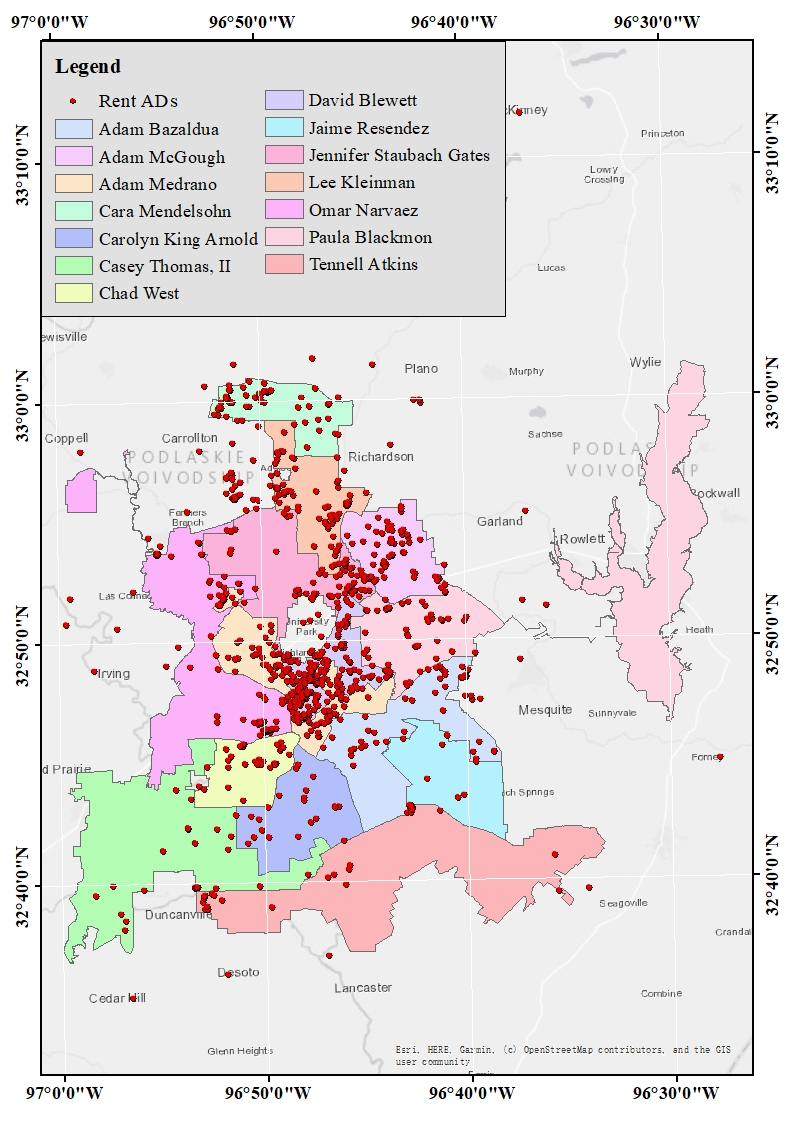

In [10]:
pt1= pd.read_excel('./Data/Craigslist_All.xlsx')
# pt1.drop_duplicates(subset ="Description", 
#                      keep = False, inplace = True) 
print(pt1.shape)
pt1 = pt1[["Rent","Bath","Bed","Area","Description"]]
pt1.head()

(6087, 10)


Rent   Bath    Bed  Area                                        Description
0  1150   2Ba    2BR   1141  2/2 bath Ready Now. This is a beautiful spacio...
1  1140   1Ba    2BR    876  Garden-style charm meets clean, modern design ...
2   910   1Ba    1BR    659  VIEW OUR WEBSITE: \n\nhttp://TheThreadApt.com ...
3   759   1Ba    1BR    600  The great luxuries you have always wanted in a...
4  1070   1Ba    1BR    678  Up to $500* off plus no deposit and half-off f...

### Split by Whitespace and Remove Punctuation

In [12]:
from string import digits

In [13]:
def clean_text(article):
    clean1 = re.sub(r'['+string.punctuation + '’—”'+']', "", article.lower())
    return re.sub(r'\W+', ' ', clean1)
remove_digits = str.maketrans('', '', digits)
pt1['tokenized'] = pt1['Description'].map(lambda x: clean_text(str(x).translate(remove_digits).strip().replace('xa0',"")))

pt1.head()

Rent   Bath    Bed  Area  \
0  1150   2Ba    2BR   1141   
1  1140   1Ba    2BR    876   
2   910   1Ba    1BR    659   
3   759   1Ba    1BR    600   
4  1070   1Ba    1BR    678   

                                         Description       Area_Cate  \
0  2/2 bath Ready Now. This is a beautiful spacio...  Area:1000-1500   
1  Garden-style charm meets clean, modern design ...      Area:<1000   
2  VIEW OUR WEBSITE: \n\nhttp://TheThreadApt.com ...      Area:<1000   
3  The great luxuries you have always wanted in a...      Area:<1000   
4  Up to $500* off plus no deposit and half-off f...      Area:<1000   

                                           tokenized  
0   bath ready now this is a beautiful spacious a...  
1  gardenstyle charm meets clean modern design in...  
2  view our website httpthethreadaptcom the threa...  
3  the great luxuries you have always wanted in a...  
4  up to off plus no deposit and halfoff fees res...

### Lemmatization

Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document. As a result, developing efficient lemmatisation algorithms is an open area of research.

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

In [20]:
lemma_word = []
wordnet_lemmatizer = WordNetLemmatizer()
for i, row in pt1.iterrows():
    word = ""
    for w in row['tokenized'].split():
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        word  = word + " " + word3
    lemma_word.append(word)
pt1['lemma_word'] = lemma_word
pt1['lemma_word'].head()

0     bath ready now this be a beautiful spacious a...
1     gardenstyle charm meet clean modern design in...
2     view our website httpthethreadaptcom the thre...
3     the great luxury you have always want in a on...
4     up to off plus no deposit and halfoff fee res...
Name: lemma_word, dtype: object

### Filtering Extremes
* Rent < 2.5% and Rent > 97.5%

<Axes: ylabel='Density'>

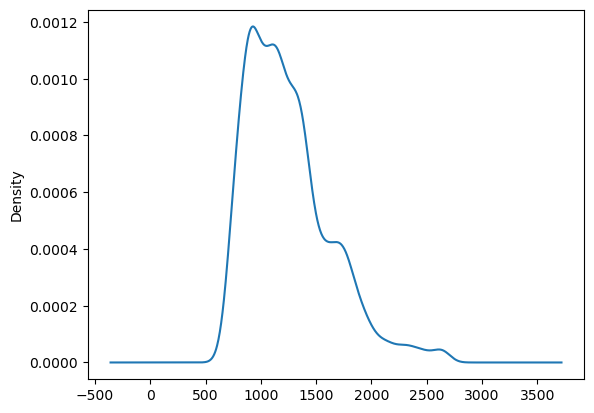

In [15]:
pt1["Rent"].plot(kind="density")

<Axes: ylabel='Density'>

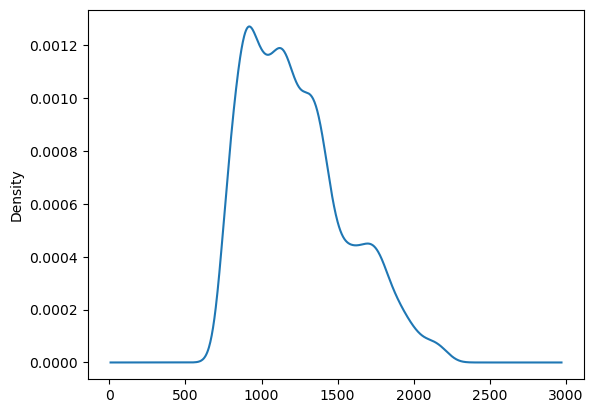

In [16]:
n_025 = pt1['Rent'].quantile(0.025)
n_975= pt1['Rent'].quantile(0.975)
pt1 = pt1[pt1['Rent']>=n_025]
pt1 = pt1[pt1['Rent']<=n_975] 
pt1["Rent"].plot(kind="density")

### Categorize Area as well

In [17]:
# Define the bins and labels for categorization
bins = [0, 1000, 1500, 2000, 2500, 3000, 4000, float('inf')]
labels = ['<1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-4000', '>4000']

# Categorize the "Area" variable
pt1['Area_Cate'] = pd.cut(pt1['Area'], bins=bins, labels=labels, right=False)

# Add the prefix "Area_" to the categories
pt1['Area_Cate'] = 'Area:' + pt1['Area_Cate'].astype(str)

# View the result
pt1.head()

Rent   Bath    Bed  Area  \
0  1150   2Ba    2BR   1141   
1  1140   1Ba    2BR    876   
2   910   1Ba    1BR    659   
3   759   1Ba    1BR    600   
4  1070   1Ba    1BR    678   

                                         Description       Area_Cate  \
0  2/2 bath Ready Now. This is a beautiful spacio...  Area:1000-1500   
1  Garden-style charm meets clean, modern design ...      Area:<1000   
2  VIEW OUR WEBSITE: \n\nhttp://TheThreadApt.com ...      Area:<1000   
3  The great luxuries you have always wanted in a...      Area:<1000   
4  Up to $500* off plus no deposit and half-off f...      Area:<1000   

                                           tokenized  
0   bath ready now this is a beautiful spacious a...  
1  gardenstyle charm meets clean modern design in...  
2  view our website httpthethreadaptcom the threa...  
3  the great luxuries you have always wanted in a...  
4  up to off plus no deposit and halfoff fees res...

### Remove stop words and merge all info into corpus

In [24]:
# nltk.download('stopwords')

In [21]:
from nltk.corpus import stopwords

In [26]:
X = []
for i, row in pt1.iterrows():
    for sw in stopwords.words('english'):
        words = row['Bath'] + " " + row['Bath'] + row['Area_Cate'] + " " + row['lemma_word']
        words.replace(sw,"")
    X.append(words)
    
pt1['corpus'] = X
pt1.head()

Rent   Bath    Bed  Area  \
0  1150   2Ba    2BR   1141   
1  1140   1Ba    2BR    876   
2   910   1Ba    1BR    659   
3   759   1Ba    1BR    600   
4  1070   1Ba    1BR    678   

                                         Description       Area_Cate  \
0  2/2 bath Ready Now. This is a beautiful spacio...  Area:1000-1500   
1  Garden-style charm meets clean, modern design ...      Area:<1000   
2  VIEW OUR WEBSITE: \n\nhttp://TheThreadApt.com ...      Area:<1000   
3  The great luxuries you have always wanted in a...      Area:<1000   
4  Up to $500* off plus no deposit and half-off f...      Area:<1000   

                                           tokenized  \
0   bath ready now this is a beautiful spacious a...   
1  gardenstyle charm meets clean modern design in...   
2  view our website httpthethreadaptcom the threa...   
3  the great luxuries you have always wanted in a...   
4  up to off plus no deposit and halfoff fees res...   

                                          lemma_word  \
0   bath ready now this be a beautiful spacious a...   
1   gardenstyle charm meet clean modern design in...   
2   view our website httpthethreadaptcom the thre...   
3   the great luxury you have always want in a on...   
4   up to off plus no deposit and halfoff fee res...   

                                              corpus  
0   2Ba   2Ba Area:1000-1500  bath ready now this...  
1   1Ba   1Ba Area:<1000  gardenstyle charm meet ...  
2   1Ba   1Ba Area:<1000  view our website httpth...  
3   1Ba   1Ba Area:<1000  the great luxury you ha...  
4   1Ba   1Ba Area:<1000  up to off plus no depos...

Text(0.5, 0, 'Number of Words')

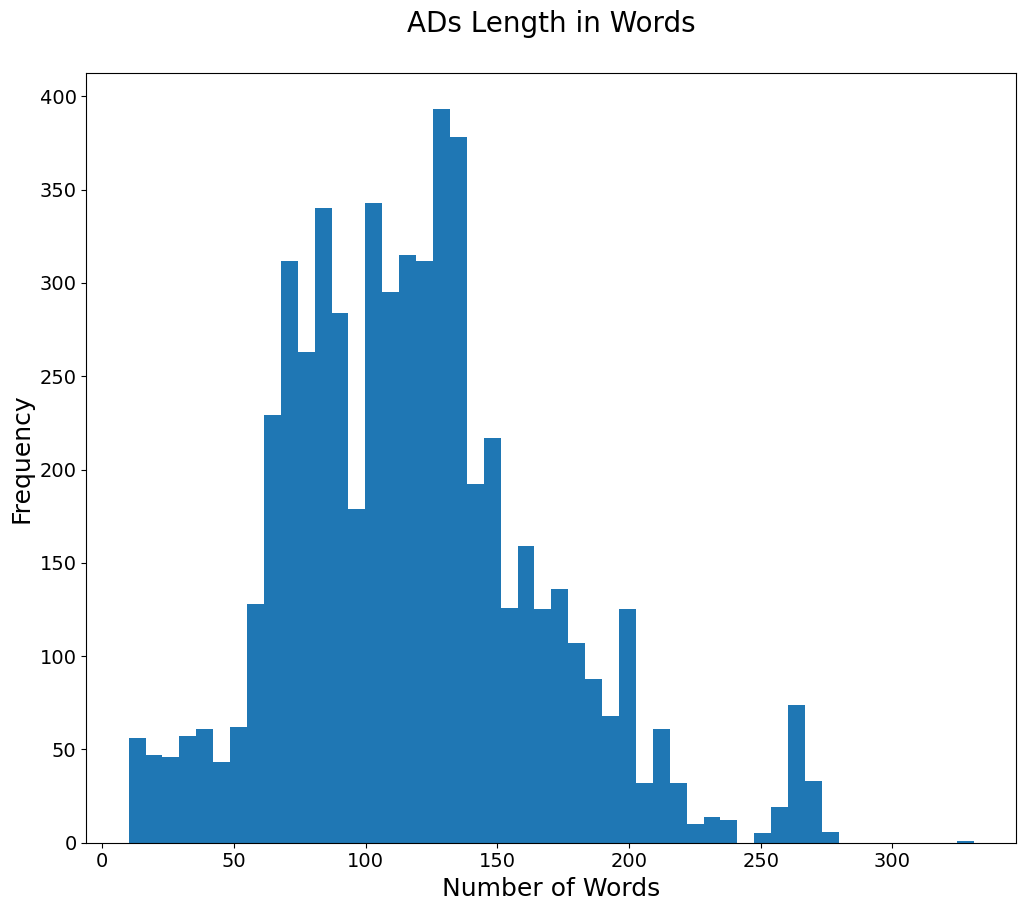

In [27]:
pt1['num_wds'] = pt1['corpus'].str.split().apply(lambda x: len(set(x)))
ax=pt1['num_wds'].plot(kind='hist', bins=50, fontsize=14, figsize=(12,10))
ax.set_title('ADs Length in Words\n', fontsize=20)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_xlabel('Number of Words', fontsize=18)

In [28]:
pt1 = pt1[pt1['num_wds']>=10]

## Tokenizing the Text
* Use `Keras`' Tokenizer to convert text to sequences of integers. 
* The number of words (`num_words`) to keep in the vocabulary is based on the unique words in your corpus.

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pt1['corpus'])
sequences = tokenizer.texts_to_sequences(pt1['corpus'])

# Pad sequences to ensure uniform input size
max_length = max(len(seq) for seq in sequences)
X_padded = pad_sequences(sequences, maxlen=max_length)

# Number of unique words in the corpus
num_words = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
num_words

9315

## Preparing the Target and Splitting the Dataset
Prepare your target variable and split the data into training and testing sets.

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# Target variable
y = pt1['Rent'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=1)

## LSTM Modeling
Create an `LSTM` model using Keras. 
* This example uses a `LSTM layer` followed by a `dense layer` with linear activation to predict the rent.

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [35]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=max_length))  # 100-dimensional word vectors
model.add(LSTM(64))  # 64 LSTM units
model.add(Dense(1, activation='linear'))  # Linear activation for regression

In [55]:
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
# # Define checkpoint callback to save the model weights
# checkpoint_path = "model_checkpoint.h5"
# checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split=0.2, callbacks=[checkpoint_callback])
# test_mse = model.evaluate(X_test, y_test)
# print(f'Test MSE: {test_mse}')

37/37 [==============================] - 14s 354ms/step


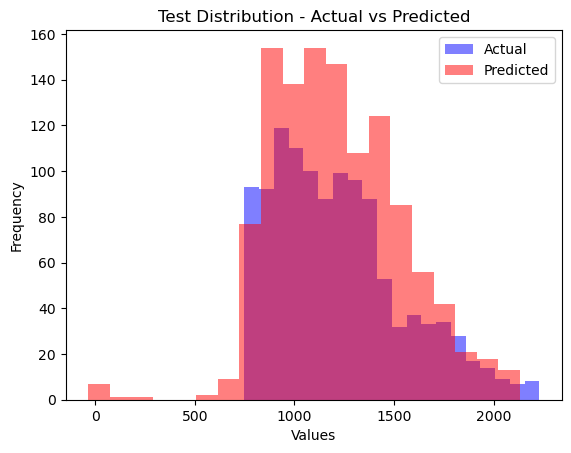

37/37 [==============================] - 14s 380ms/step
Test MSE: 50717.8789
Test MAE: 152.9201
Test MAPE: 30.9241%


In [52]:
# Print test distribution
plt.hist(y_test, bins=20, color='blue', alpha=0.5, label='Actual')
plt.hist(model.predict(X_test), bins=20, color='red', alpha=0.5, label='Predicted')
plt.legend()
plt.title('Test Distribution - Actual vs Predicted')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

# Evaluate the model on the test set
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Calculate MAPE
y_pred = model.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {mape:.4f}%')

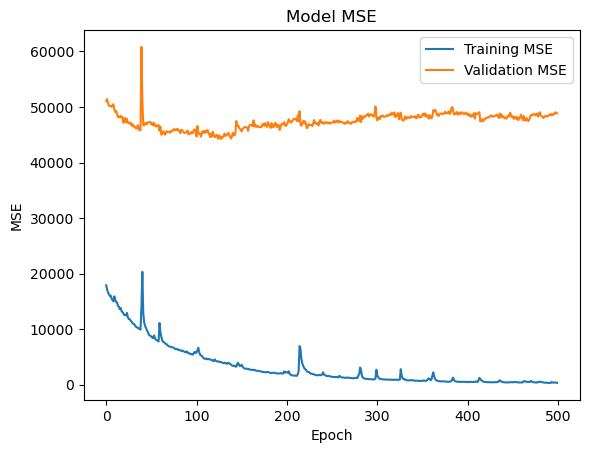

In [53]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Test
* [Sample 1](https://dallas.craigslist.org/ftw/apa/d/fort-worth-get-lucky-with-one-month-free/7722463894.html)    
  
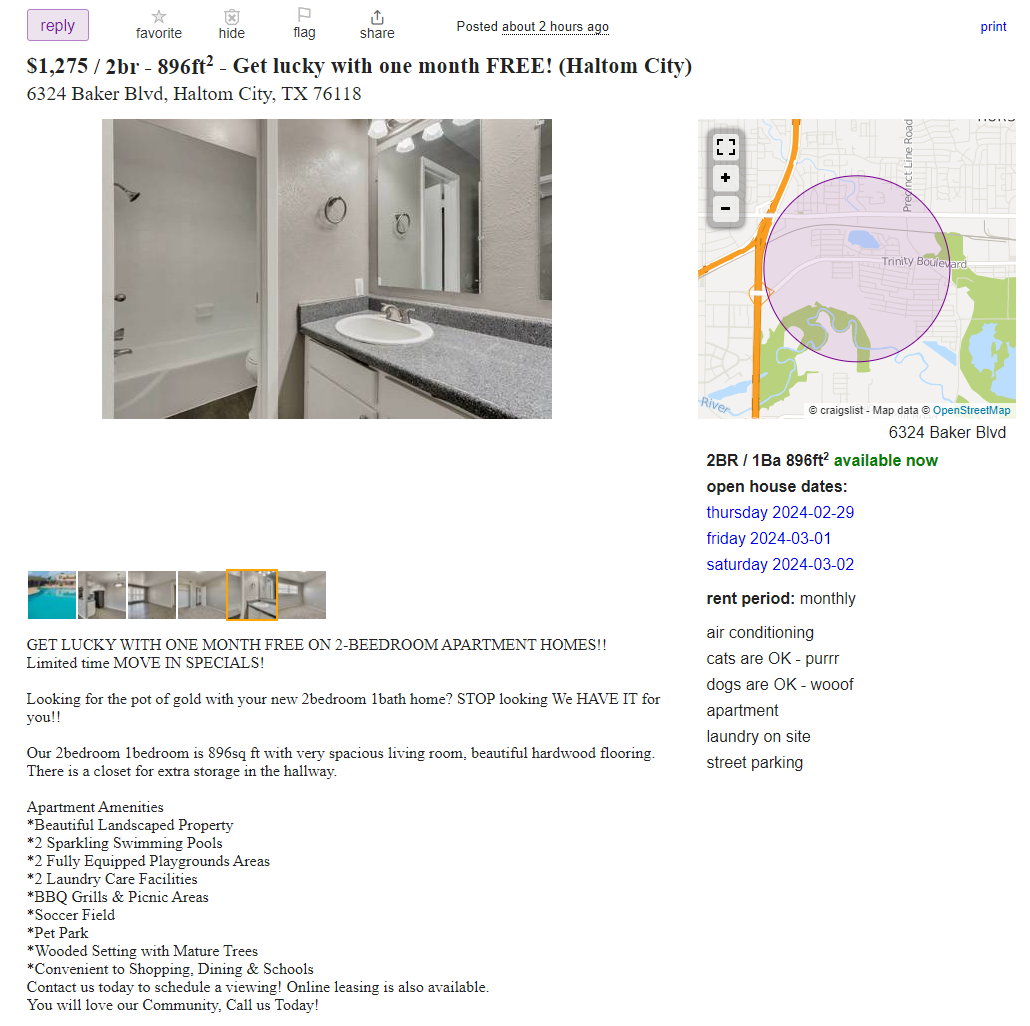

In [54]:
def predict_rent(description):
    # Preprocess the description
    cleaned = clean_text(description)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in cleaned.split()])
    seq = tokenizer.texts_to_sequences([lemmatized])
    padded = pad_sequences(seq, maxlen=max_length)
    
    # Predict
    predicted_rent = model.predict(padded)
    return predicted_rent[0][0]

# Example usage
description = """
GET LUCKY WITH ONE MONTH FREE ON 2-BEEDROOM APARTMENT HOMES!!
Limited time MOVE IN SPECIALS!

Looking for the pot of gold with your new 2bedroom 1bath home? STOP looking We HAVE IT for you!!

Our 2bedroom 1bedroom is 896sq ft with very spacious living room, beautiful hardwood flooring. There is a closet for extra storage in the hallway.

Apartment Amenities
*Beautiful Landscaped Property
*2 Sparkling Swimming Pools
*2 Fully Equipped Playgrounds Areas
*2 Laundry Care Facilities
*BBQ Grills & Picnic Areas
*Soccer Field
*Pet Park
*Wooded Setting with Mature Trees
*Convenient to Shopping, Dining & Schools
Contact us today to schedule a viewing! Online leasing is also available.
You will love our Community, Call us Today!

"""
predicted = predict_rent(description)
predicted

1/1 [==============================] - 0s 320ms/step


1091.9424

* [Sample 2](https://dallas.craigslist.org/mdf/apa/d/lewisville-barrow-apartments-move-in/7713714487.html)    

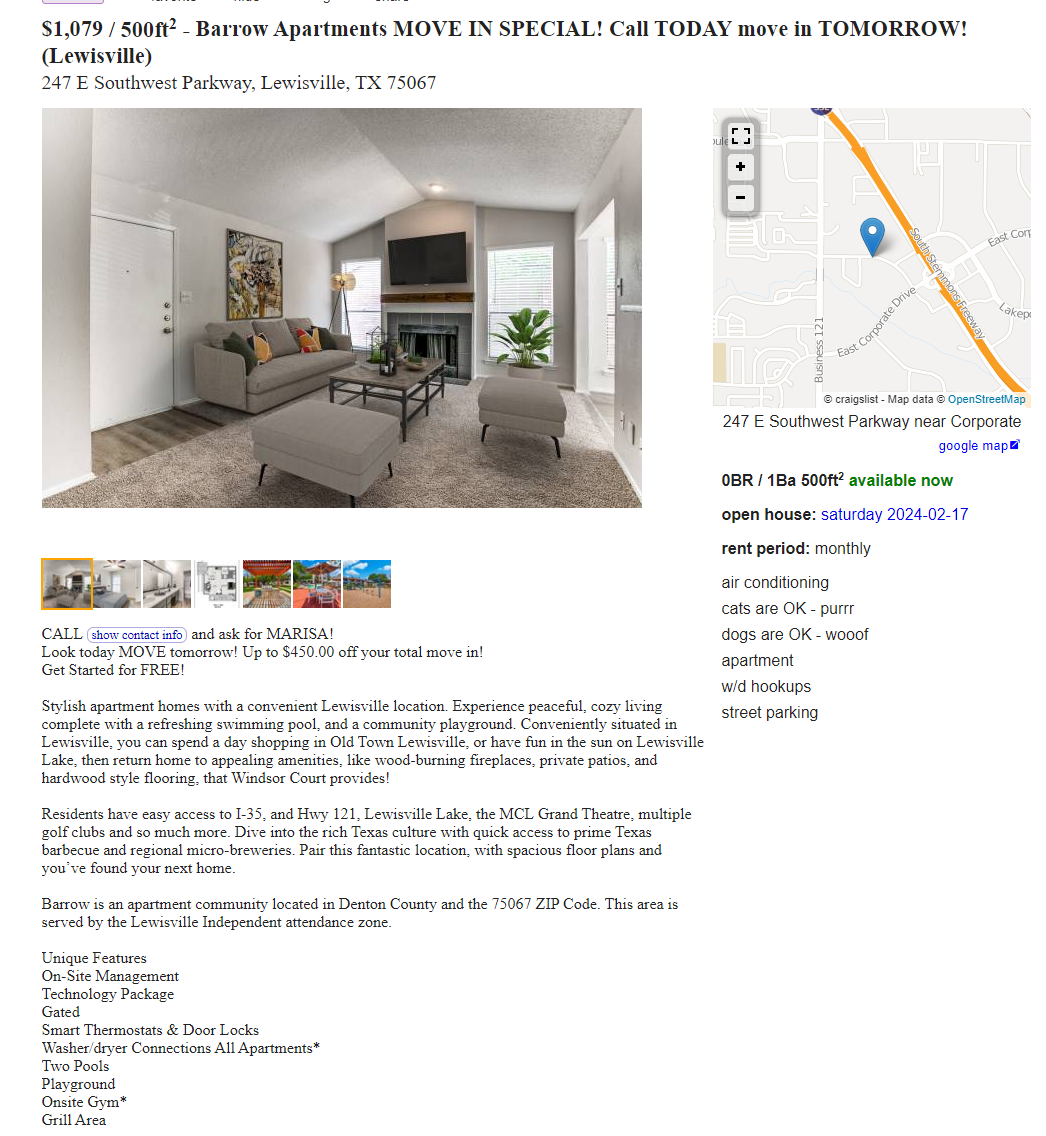

In [56]:
# Example usage
description = """
Look today MOVE tomorrow! Up to $450.00 off your total move in!
Get Started for FREE!

Stylish apartment homes with a convenient Lewisville location. Experience peaceful, cozy living complete with a refreshing swimming pool, and a community playground. Conveniently situated in Lewisville, you can spend a day shopping in Old Town Lewisville, or have fun in the sun on Lewisville Lake, then return home to appealing amenities, like wood-burning fireplaces, private patios, and hardwood style flooring, that Windsor Court provides!

Residents have easy access to I-35, and Hwy 121, Lewisville Lake, the MCL Grand Theatre, multiple golf clubs and so much more. Dive into the rich Texas culture with quick access to prime Texas barbecue and regional micro-breweries. Pair this fantastic location, with spacious floor plans and you’ve found your next home.

Barrow is an apartment community located in Denton County and the 75067 ZIP Code. This area is served by the Lewisville Independent attendance zone.

Unique Features
On-Site Management
Technology Package
Gated
Smart Thermostats & Door Locks
Washer/dryer Connections All Apartments*
Two Pools
Playground
Onsite Gym*
Grill Area

Call for our Move in Special!
"""
predicted = predict_rent(description)
predicted

1/1 [==============================] - 0s 388ms/step


1229.9175

## Understand the model

### Attention Weights
* In the realm of natural language processing (NLP) and sequence modeling, `attention weights` play a pivotal role in understanding how models process input sequences and make predictions. At its core, attention mechanism mimics the human cognitive process of selectively focusing on relevant information while processing a task.
* In the context of `NLP`, attention weights represent the **degree of importance or relevance** assigned to each word or token in a sequence when generating an output, such as a translation, sentiment score, or prediction. 
  * **Higher attention weights indicate that the model assigns greater significance to the corresponding word**, suggesting its crucial role in determining the output.

In [65]:
from keras.models import Model

1/1 [==============================] - 1s 871ms/step


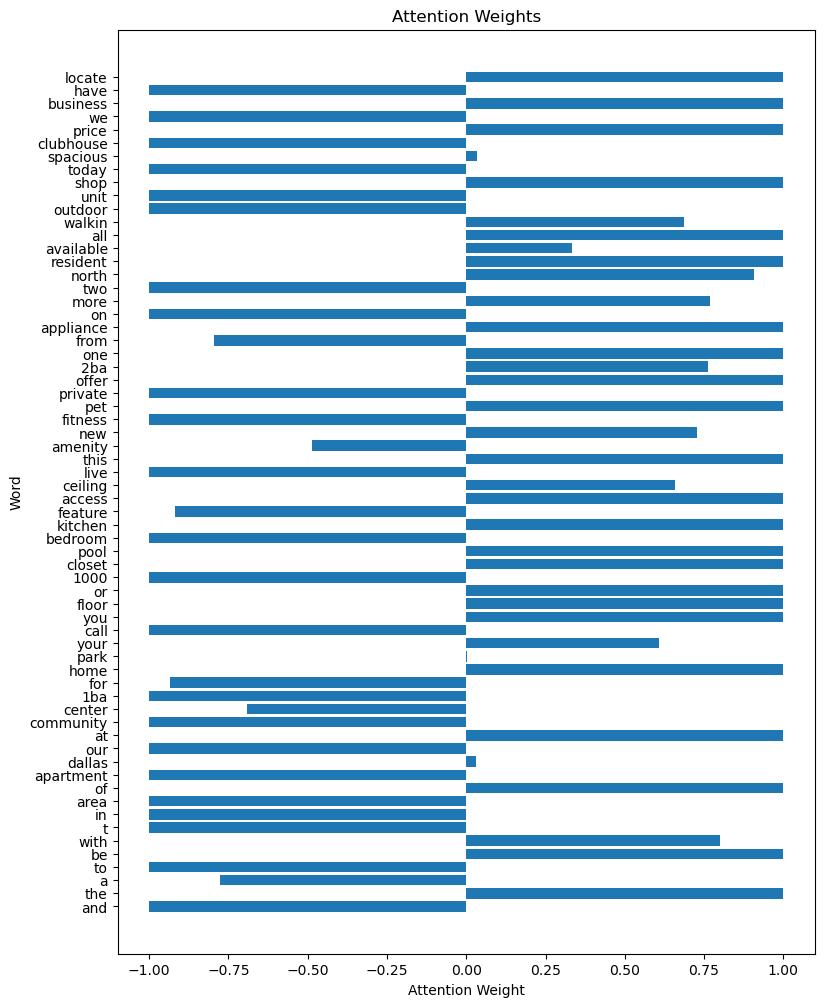

In [80]:
# Define a custom model
attention_model = Model(inputs=model.input,
                        outputs=[model.output, model.layers[1].output])

# Generate predictions and attention weights for a sample
predictions, attention_weights = attention_model.predict(X_test[:1])

# Get the mapping from word index to word
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# Plot attention weights with real words on y-axis
plt.figure(figsize=(9, 12))  # Set the size of the figure
plt.barh([index_to_word[i+1] for i in range(len(attention_weights[0]))], attention_weights[0])
plt.ylabel('Word')
plt.xlabel('Attention Weight')
plt.title('Attention Weights')
plt.show()